#### Detect model from Yu, et al
Implementation of the detection model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

Data was resized to 224x224 and median filtered 7x7. None type was subsampled to keep only 30,000 random samples.

Refinement on first run. Still tries to follow the paper as closely as possible, but some changes from the first run:
- Added last fully connected layer (FC3) that was accidentally omitted in the first run.
- Saved both model and predictions.

In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, optimizers

import os
import numpy as np
import pandas as pd
import pickle5 as pickle

import helpers as helper
import seaborn as sns
from sklearn.metrics import confusion_matrix

import time

In [4]:
# specify variables for model
path = '../../data/resized224'
filename = 'WM-clean-id224filter7'
option = '-detund' # -clsaug, -detund
map_column = 'filterMap7'
label_column = 'detectLabels'
filetype = 'zip' # zip, pkl

model_id = 'yudetect'
result_path = '../../results'
note = '-refined2' # -optional

In [5]:
# load train, dev, and test sets
start = time.time()

if filetype == 'pkl':
    # open pkl files
    with open(f'{path}/{filename}-train{option}.pkl', "rb") as fh:
        train = pickle.load(fh)
    with open(f'{path}/{filename}-dev.pkl', "rb") as fh:
        dev = pickle.load(fh)
    with open(f'{path}/{filename}-test.pkl', "rb") as fh:
        test = pickle.load(fh)

elif filetype == 'zip':
    train = helper.load(f'{path}/{filename}-train{option}.zip')
    dev = helper.load(f'{path}/{filename}-dev.zip')
    test = helper.load(f'{path}/{filename}-test.zip')

print("Wall time: {} seconds".format(time.time() - start))
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

Wall time: 96.14158701896667 seconds
Train: 47863
Dev: 25942
Test: 25943


#### Quick EDA

In [6]:
# baseline accuracy of test set
nones = len(test[test.failureType == 'none'])
total = len(test)
print(f"Baseline accuracy: {nones/total*100:.2f}%")

Baseline accuracy: 85.24%


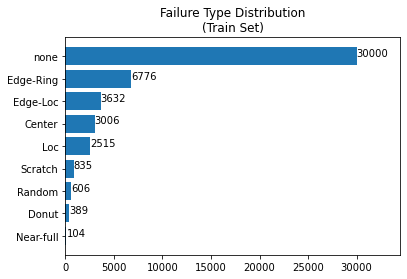

In [7]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set')

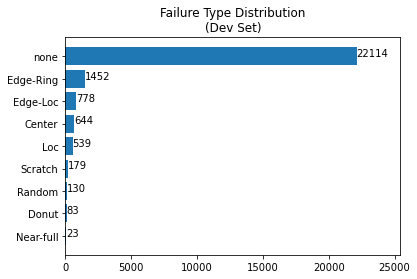

In [8]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set')

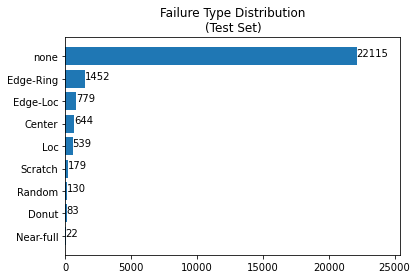

In [9]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set')

#### Data set-up

In [10]:
# prepare inputs
start = time.time()

x_train = np.stack(train[map_column])
x_val = np.stack(dev[map_column])
x_test = np.stack(test[map_column])

print("Wall time: {} seconds".format(time.time() - start))

# sanity check
# expected: (#rows, xdim, ydim)
x_train.shape

Wall time: 82.62807011604309 seconds


(47863, 224, 224)

In [11]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

print("Wall time: {} seconds".format(time.time() - start))

# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

Wall time: 0.11629891395568848 seconds


TensorShape([47863, 224, 224, 1])

In [12]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
y_train = np.asarray(train[label_column]).astype('int64')
y_val = np.asarray(dev[label_column]).astype('int64')
y_test = np.asarray(test[label_column]).astype('int64')

# sanity check
# expected: type = int
type(y_train[0])

numpy.int64

#### Model

In [13]:
# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [14]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [15]:
# run model
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
748/748 [==============================] - 677s 903ms/step - loss: 0.3232 - accuracy: 0.8674 - val_loss: 0.1223 - val_accuracy: 0.9611
Epoch 2/10
748/748 [==============================] - 657s 879ms/step - loss: 0.1448 - accuracy: 0.9456 - val_loss: 0.0771 - val_accuracy: 0.9740
Epoch 3/10
748/748 [==============================] - 669s 894ms/step - loss: 0.1086 - accuracy: 0.9590 - val_loss: 0.0739 - val_accuracy: 0.9735
Epoch 4/10
748/748 [==============================] - 647s 865ms/step - loss: 0.0887 - accuracy: 0.9673 - val_loss: 0.0611 - val_accuracy: 0.9793
Epoch 5/10
748/748 [==============================] - 647s 865ms/step - loss: 0.0734 - accuracy: 0.9722 - val_loss: 0.1052 - val_accuracy: 0.9610
Epoch 6/10
748/748 [==============================] - 645s 862ms/step - loss: 0.0615 - accuracy: 0.9765 - val_loss: 0.0623 - val_accuracy: 0.9773
Epoch 7/10
748/748 [==============================] - 657s 879ms/step - loss: 0.0512 - accuracy: 0.9805 - val_loss: 0.0590 -

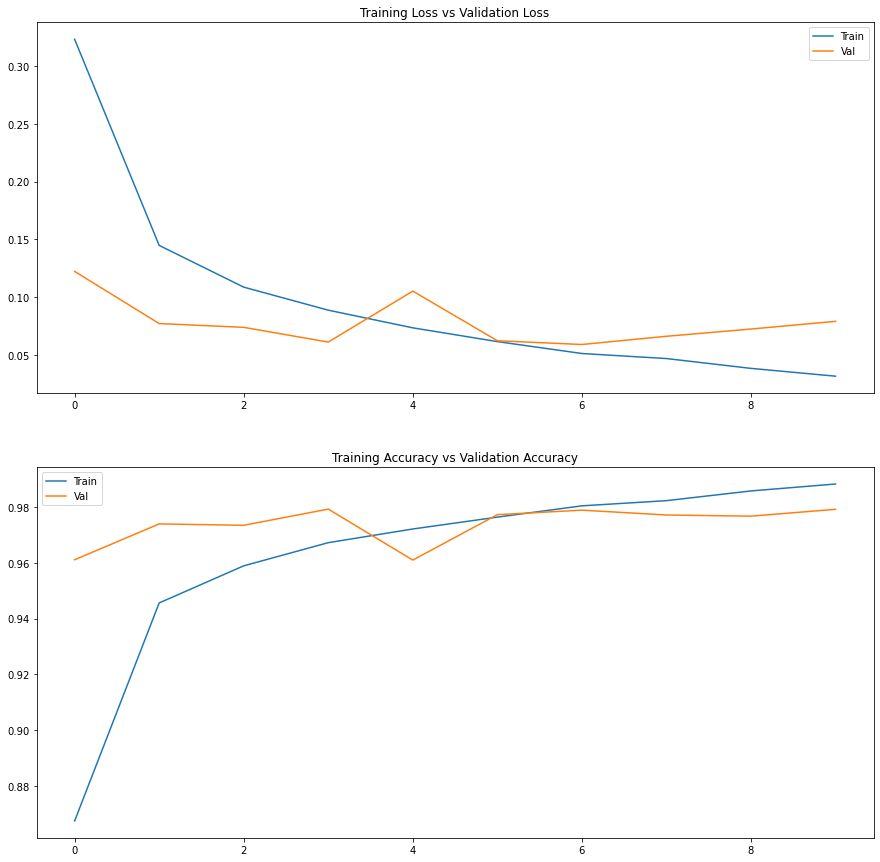

In [16]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [17]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {} seconds".format(time.time() - start))
print()
print(results)

811/811 [==============================] - 117s 144ms/step - loss: 0.0744 - accuracy: 0.9808
Wall time: 116.94756007194519 seconds

[0.0744197815656662, 0.9807655215263367]


In [18]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 121.12465691566467 seconds


In [19]:
# save results, history, and predictions
with open(f'{result_path}/{model_id}-{filename}{option}{note}.pkl', "wb") as f:
    pickle.dump(y_pred, f)

# changed note to -refined2

In [20]:
# save model
model.save(f'{result_path}/{model_id}-{filename}{option}{note}')

# changed note to -refined2

INFO:tensorflow:Assets written to: ../../results/yudetect-WM-clean-id224filter7-detund-firstrun2/assets


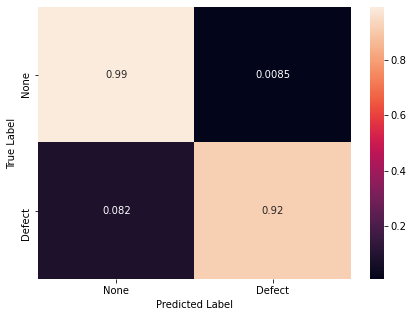

In [21]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_pred, mode='detect', normalize=True)

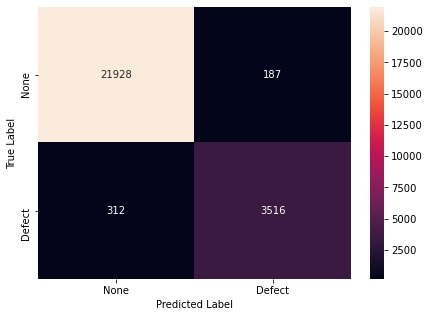

In [22]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_pred, mode='detect', normalize=False)